In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
encoder = OneHotEncoder()
train = pd.read_csv('/gdrive/My Drive/Data/train1.csv')
test = pd.read_csv('/gdrive/My Drive/Data/test1.csv')
sample_sub = pd.read_csv('/gdrive/My Drive/Data/sample_submission1.csv')
df = pd.concat([train,test],axis=0,sort=False)
df.drop(['X14','X16','X19'],axis=1, inplace=True)
for col in df.columns:
  col_type = df[col].dtypes
  if str(col_type)[:3] == 'int':
    df[col] = df[col].astype(np.int16)
  else:
    df[col] = df[col].astype(np.float32)
x_col = df.loc[:,"X00":"X39"].columns
y_col = df.loc[:,"Y00":"Y17"].columns
not_col = df.columns.difference(x_col)

minute = (df.id%144).astype(int)
hour= pd.Series((df.index%144/6).astype(int))
min_in_day = 24*6
hour_in_day = 24

minute_sin = np.sin(2*np.pi*minute/min_in_day) 
minute_cos = np.cos(2*np.pi*minute/min_in_day)
hour_sin  = np.sin(2*np.pi*hour/hour_in_day)
hour_cos  = np.cos(2*np.pi*hour/hour_in_day)

df["minute_sin"], df["minute_cos"],df["hour_sin"],df["hour_cos"] = minute_sin, minute_cos, hour_sin, hour_cos
train = df.iloc[:train.shape[0],:]
test = df.iloc[train.shape[0]:,:]

def standardization(df):
    mean = df.mean()
    std = df.std()
    norm = (df - mean) / (std - 1e-07)
    return norm, mean, std
train_norm, train_mean, train_std = standardization(train[x_col])
test_norm = (test[x_col] - train_mean) / (train_std - 1e-07)

train1 = pd.concat([train["id"], train_norm, train.loc[:,"minute_sin":"hour_cos"]], axis=1) 
test1  = pd.concat([test["id"] , test_norm, test.loc[:,"minute_sin":"hour_cos"]] , axis=1)

In [0]:
train2 = train1.iloc[:4320,:]
train3 = train1.iloc[4320:,:].reset_index(drop=True)
train_y = train.iloc[:4320,][y_col]
train18 = train.loc[4320:,"Y18"].reset_index(drop=True)

In [164]:
train18

0      20.5
1      20.5
2      20.5
3      20.5
4      20.5
       ... 
427    21.5
428    21.5
429    21.5
430    21.5
431    21.0
Name: Y18, Length: 432, dtype: float32

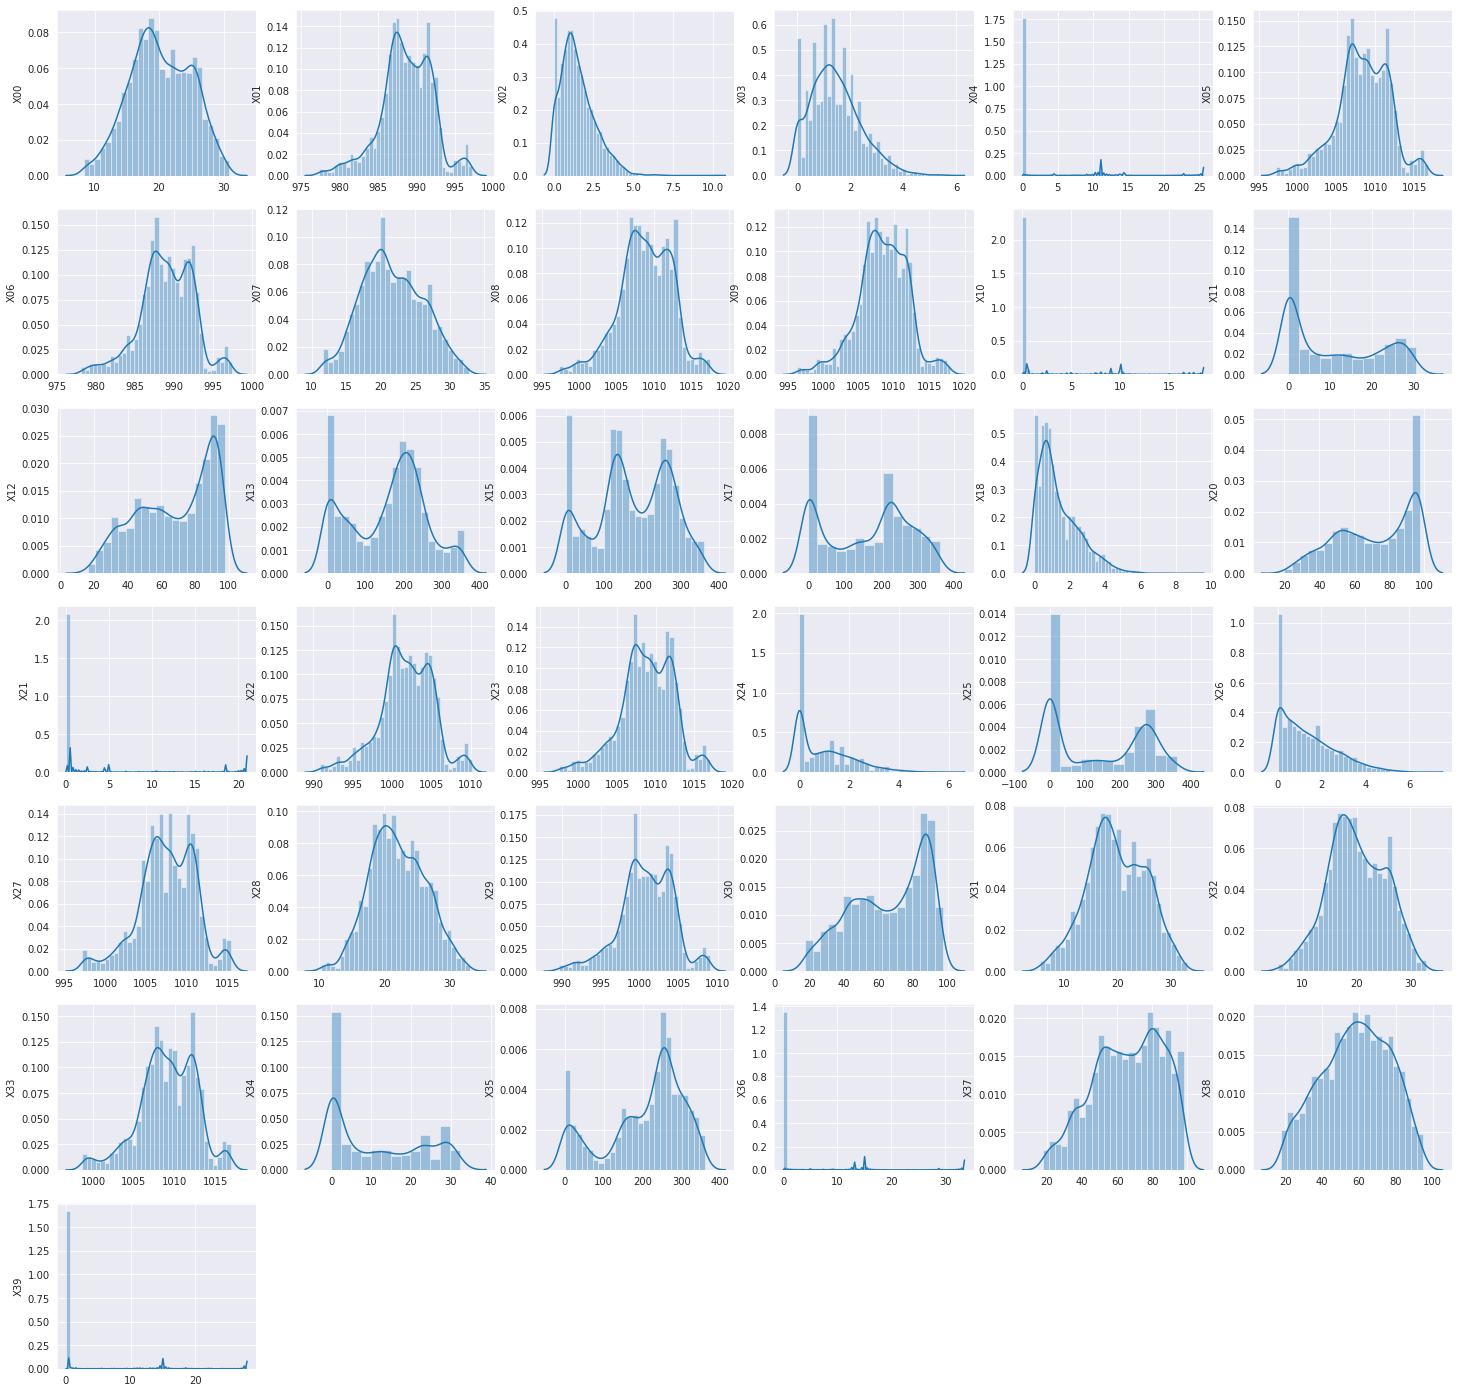

In [50]:
sns.set_style("darkgrid")
plt.figure(figsize=(25,25))
for i, col in enumerate(train1.columns[1:38]):
    plt.subplot(7,6,i+1)
    sns.distplot(train[col])
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

In [69]:
import keras
from keras.models import Sequential
from keras import backend as K
from keras.utils import get_custom_objects
from keras.layers import Dense, Dropout, LSTM, Input, Activation, BatchNormalization
from keras import optimizers

train_reshaped = np.expand_dims(train2 ,axis=1)
print(train_reshaped.shape[-2:])
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

model = Sequential()
model.add(LSTM(250, return_sequences= True,input_shape=train_reshaped.shape[-2:],activation='mish'))
model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences= False,activation='mish',))
model.add(Dense(100,activation='mish'))

model.add(Dense(50,activation='linear'))
model.add(Dense(18,activation='linear'))
adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')
model.summary()

(1, 42)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 250)            293000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 250)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               140400    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 18)                918       
Total params: 449,468
Trainable params: 449,468
Non-trainable params: 0
________________________________________

In [73]:
model.fit(train_reshaped, train_y ,batch_size=128, epochs=10,validation_split=0.15, shuffle=False)

Train on 3672 samples, validate on 648 samples
Epoch 1/10
3672/3672 [==============================] - 0s 126us/step - loss: 71.9619 - val_loss: 57.6286
Epoch 2/10
3672/3672 [==============================] - 0s 119us/step - loss: 97.6562 - val_loss: 34.2126
Epoch 3/10
3672/3672 [==============================] - 0s 123us/step - loss: 82.9982 - val_loss: 46.3813
Epoch 4/10
3672/3672 [==============================] - 0s 115us/step - loss: 77.8052 - val_loss: 37.3569
Epoch 5/10
3672/3672 [==============================] - 0s 128us/step - loss: 83.6910 - val_loss: 39.5292
Epoch 6/10
3672/3672 [==============================] - 0s 115us/step - loss: 96.1596 - val_loss: 40.1124
Epoch 7/10
3672/3672 [==============================] - 0s 119us/step - loss: 78.8193 - val_loss: 37.9637
Epoch 8/10
3672/3672 [==============================] - 0s 129us/step - loss: 86.1038 - val_loss: 35.1015
Epoch 9/10
3672/3672 [==============================] - 0s 117us/step - loss: 99.5106 - val_loss: 57.4367

In [74]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
plt.figure(figsize = (13,8))
class LRFinder(Callback):
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        self.total_iterations = steps_per_epoch * epochs
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

<Figure size 936x576 with 0 Axes>

In [0]:
epochs = 50
batch_size = 12
epoch_size = train2.shape[0]

early_stop = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

ckpt_dir = '/gdrive/My Drive/ckpt1'
ckpt_path = ckpt_dir + '/model3_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
# model.fit(train_reshaped, train_y,batch_size=64, epochs=50,validation_split=0.15,callbacks=[lr_finder,early_stop],shuffle=False)

In [150]:
model.load_weights('/gdrive/My Drive/ckpt1/model2_11_valloss2.41.hdf5')
model.fit(train_reshaped, train_y,batch_size=12, epochs=30,validation_split=0.1,callbacks=[ckpt, lr_finder,early_stop],shuffle=False)

Train on 3888 samples, validate on 432 samples
Epoch 1/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.5895 - val_loss: 2.5602
Epoch 2/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.2775 - val_loss: 2.6647
Epoch 3/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.0231 - val_loss: 2.7290
Epoch 4/30
3888/3888 [==============================] - 5s 1ms/step - loss: 3.9084 - val_loss: 2.8665
Epoch 5/30
3888/3888 [==============================] - 5s 1ms/step - loss: 3.8816 - val_loss: 3.0963
Epoch 6/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.0043 - val_loss: 3.4665
Epoch 7/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.0046 - val_loss: 3.6026
Epoch 8/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.0821 - val_loss: 3.8406
Epoch 9/30
3888/3888 [==============================] - 5s 1ms/step - loss: 4.1517 - val_loss: 4.1519
Epoch 10/30
3888/3888 [============

In [155]:
model.load_weights('/gdrive/My Drive/ckpt1/model2_11_valloss2.41.hdf5')
y017 = model.predict(np.expand_dims(train3,axis=1))
y017 = pd.DataFrame(y017,columns=y_col)
y017.head()

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
0,19.432991,19.817572,19.844601,23.385498,23.434607,19.432669,17.963846,18.531515,18.851442,17.063591,17.707447,18.099833,18.288105,17.360956,17.418745,17.268049,17.941158,17.531803
1,19.309124,19.661303,19.687712,23.260509,23.307962,19.337557,17.874836,18.445072,18.754499,16.961143,17.602917,17.972799,18.205093,17.279737,17.326326,17.188198,17.850765,17.449476
2,19.371441,19.655750,19.684170,23.378521,23.423355,19.235035,17.779743,18.354765,18.640989,16.842043,17.464138,17.775675,18.066935,17.238667,17.304930,17.125481,17.722244,17.361906
3,19.494471,19.807470,19.837063,23.503359,23.549726,19.328091,17.865576,18.438480,18.736059,16.939384,17.563519,17.895590,18.147350,17.319935,17.396158,17.204475,17.810612,17.439808
4,19.471027,19.769724,19.799324,23.485115,23.530869,19.293957,17.834270,18.408031,18.700731,16.903090,17.525209,17.845913,18.112442,17.296026,17.372005,17.178665,17.775017,17.411589


In [174]:
y_train = pd.concat([y017,train18],axis=1,sort=False)
y_train.head()

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,19.432991,19.817572,19.844601,23.385498,23.434607,19.432669,17.963846,18.531515,18.851442,17.063591,17.707447,18.099833,18.288105,17.360956,17.418745,17.268049,17.941158,17.531803,20.5
1,19.309124,19.661303,19.687712,23.260509,23.307962,19.337557,17.874836,18.445072,18.754499,16.961143,17.602917,17.972799,18.205093,17.279737,17.326326,17.188198,17.850765,17.449476,20.5
2,19.371441,19.655750,19.684170,23.378521,23.423355,19.235035,17.779743,18.354765,18.640989,16.842043,17.464138,17.775675,18.066935,17.238667,17.304930,17.125481,17.722244,17.361906,20.5
3,19.494471,19.807470,19.837063,23.503359,23.549726,19.328091,17.865576,18.438480,18.736059,16.939384,17.563519,17.895590,18.147350,17.319935,17.396158,17.204475,17.810612,17.439808,20.5
4,19.471027,19.769724,19.799324,23.485115,23.530869,19.293957,17.834270,18.408031,18.700731,16.903090,17.525209,17.845913,18.112442,17.296026,17.372005,17.178665,17.775017,17.411589,20.5


In [212]:
def high_corr(df, col, ratio):
    Y_corr = df.corr()
    Y_high = Y_corr.loc[:,(Y_corr[col]> ratio)|(Y_corr[col] < -ratio)].columns
    return Y_high.drop(col)
Y_high = high_corr(y_train, "Y18", 0.9)
print(Y_high)


Index(['Y06', 'Y07', 'Y09', 'Y10', 'Y11', 'Y12', 'Y15', 'Y16', 'Y17'], dtype='object')


In [0]:
y_train = pd.concat([train3,y017],axis=1,sort=False)

In [249]:
model1 = Sequential()
model1.add(LSTM(100, return_sequences=False, input_shape=(1,y_train.shape[1]),activation='mish' ))
# model.add(LSTM(50, return_sequences= False,activation='relu',))
model1.add(Dense(50,activation='mish'))
# model1.add(BatchNormalization())
model1.add(Dense(30,activation='mish'))
model1.add(Dense(1,activation='linear'))
adam = optimizers.Adam(lr=0.0005)

model1.compile(optimizer=adam, loss='mse')
model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               64400     
_________________________________________________________________
dense_43 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_44 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 31        
Total params: 71,011
Trainable params: 71,011
Non-trainable params: 0
_________________________________________________________________


In [253]:
ckpt_dir = '/gdrive/My Drive/ckpt1'
ckpt_path = ckpt_dir + '/model3_{epoch:02d}_valloss{loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='var_loss', verbose=0, save_best_only=True, mode='min')
epochs = 100
batch_size = 24
epoch_size = y017.shape[0]

early_stop = keras.callbacks.EarlyStopping(patience=20, monitor='loss')
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
model1.fit(np.expand_dims(y_train,axis=1),train18,batch_size=24,validation_split=0.1, epochs=100,callbacks=[early_stop, lr_finder])

Train on 388 samples, validate on 44 samples
Epoch 1/100
388/388 [==============================] - 0s 490us/step - loss: 3.8476 - val_loss: 0.2090
Epoch 2/100
388/388 [==============================] - 0s 528us/step - loss: 3.7261 - val_loss: 0.6369
Epoch 3/100
388/388 [==============================] - 0s 445us/step - loss: 3.6694 - val_loss: 0.4914
Epoch 4/100
388/388 [==============================] - 0s 442us/step - loss: 3.6266 - val_loss: 0.9799
Epoch 5/100
388/388 [==============================] - 0s 449us/step - loss: 3.7852 - val_loss: 0.8712
Epoch 6/100
388/388 [==============================] - 0s 493us/step - loss: 3.7105 - val_loss: 0.5218
Epoch 7/100
388/388 [==============================] - 0s 479us/step - loss: 3.8138 - val_loss: 1.6447
Epoch 8/100
388/388 [==============================] - 0s 545us/step - loss: 3.7524 - val_loss: 0.7088
Epoch 9/100
388/388 [==============================] - 0s 468us/step - loss: 3.9934 - val_loss: 0.2205
Epoch 10/100
388/388 [======

In [199]:
ckpt_dir = '/gdrive/My Drive/ckpt2'
ckpt_path = ckpt_dir + '/model1_{epoch:02d}_valloss{loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='var_loss', verbose=0, save_best_only=True, mode='min')
epochs = 100
batch_size = 12
epoch_size = y017.shape[0]

early_stop = keras.callbacks.EarlyStopping(patience=20, monitor='loss')
lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
model1.load_weights('/gdrive/My Drive/ckpt2/model1_81_valloss1.54.hdf5')
model1.fit(np.expand_dims(y017,axis=1),train18,batch_size=12,validation_split=0.05, epochs=100,callbacks=[lr_finder,early_stop])

Train on 388 samples, validate on 44 samples
Epoch 1/200
388/388 [==============================] - 0s 957us/step - loss: 1.7352 - val_loss: 0.9535
Epoch 2/200
228/388 [================>.............] - ETA: 0s - loss: 1.6028

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with var_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


388/388 [==============================] - 0s 849us/step - loss: 1.5495 - val_loss: 2.0786
Epoch 3/200
388/388 [==============================] - 0s 848us/step - loss: 1.6509 - val_loss: 1.6663
Epoch 4/200
388/388 [==============================] - 0s 997us/step - loss: 1.7797 - val_loss: 1.5591
Epoch 5/200
388/388 [==============================] - 0s 914us/step - loss: 1.5938 - val_loss: 0.9621
Epoch 6/200
388/388 [==============================] - 0s 910us/step - loss: 1.6004 - val_loss: 1.3707
Epoch 7/200
388/388 [==============================] - 0s 930us/step - loss: 1.5498 - val_loss: 1.1046
Epoch 8/200
388/388 [==============================] - 0s 861us/step - loss: 1.5083 - val_loss: 1.7379
Epoch 9/200
388/388 [==============================] - 0s 876us/step - loss: 1.5699 - val_loss: 3.0186
Epoch 10/200
388/388 [==============================] - 0s 945us/step - loss: 1.6838 - val_loss: 1.6368
Epoch 11/200
388/388 [==============================] - 0s 863us/step - loss: 1.6639

In [0]:
yt017 = model.predict(np.expand_dims(test,axis=1))

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y18,hour
X00,1.000000,-0.696720,0.440166,0.300344,NaN,-0.730695,-0.701124,0.944908,-0.777789,-0.785817,-0.076724,0.594476,-0.886610,0.173283,-0.021463,0.303033,0.692302,-0.967237,-0.068537,-0.706988,-0.727793,0.778122,0.581917,0.621905,-0.678161,0.924128,-0.694877,-0.884103,0.937889,0.924167,-0.695748,0.612575,0.205820,NaN,-0.943287,-0.902065,0.102556,0.847230,0.538593
X01,-0.696720,1.000000,-0.447365,-0.294557,NaN,0.961756,0.982726,-0.682473,0.972826,0.987940,0.175013,-0.523687,0.621786,-0.118405,-0.264896,-0.349187,-0.493382,0.656779,0.158382,0.965681,0.973770,-0.502816,-0.348428,-0.527947,0.970266,-0.670913,0.975725,0.615949,-0.649316,-0.612120,0.970067,-0.562285,-0.048601,NaN,0.696238,0.642507,-0.093939,-0.469846,-0.368268
X02,0.440166,-0.447365,1.000000,0.206428,NaN,-0.479808,-0.471977,0.435400,-0.483359,-0.456900,0.074002,0.340910,-0.334254,0.085013,0.195446,0.159972,0.363650,-0.424916,0.107573,-0.472819,-0.476762,0.328928,0.274054,0.309952,-0.462472,0.459094,-0.469067,-0.383353,0.351383,0.392272,-0.468204,0.343533,-0.011653,NaN,-0.443812,-0.443446,0.210160,0.346297,0.254406
X03,0.300344,-0.294557,0.206428,1.000000,NaN,-0.299973,-0.318951,0.303423,-0.326369,-0.308741,-0.021169,0.247194,-0.266408,0.059514,0.083216,0.125422,0.235622,-0.284736,0.001721,-0.295444,-0.324300,0.204122,0.200558,0.308729,-0.314707,0.275629,-0.320286,-0.287687,0.280043,0.284122,-0.318467,0.266386,0.012769,NaN,-0.299352,-0.295032,0.035041,0.234911,0.236408
X04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X05,-0.730695,0.961756,-0.479808,-0.299973,NaN,1.000000,0.964957,-0.729163,0.957938,0.954025,0.012442,-0.626618,0.591310,-0.127396,-0.192379,-0.357919,-0.479952,0.647315,-0.020808,0.998932,0.986579,-0.518316,-0.391944,-0.582313,0.972912,-0.772202,0.984826,0.595847,-0.637963,-0.625722,0.974671,-0.639190,-0.015809,NaN,0.728059,0.752784,-0.308303,-0.484977,-0.469972
X06,-0.701124,0.982726,-0.471977,-0.318951,NaN,0.964957,1.000000,-0.695749,0.989530,0.972398,0.153129,-0.511806,0.621290,-0.114372,-0.260130,-0.341382,-0.510769,0.649411,0.117818,0.968341,0.985148,-0.500333,-0.337355,-0.547430,0.982268,-0.685835,0.986983,0.631506,-0.645177,-0.623382,0.981708,-0.546013,-0.004143,NaN,0.712982,0.671160,-0.130987,-0.502424,-0.356921
X07,0.944908,-0.682473,0.435400,0.303423,NaN,-0.729163,-0.695749,1.000000,-0.780651,-0.770639,-0.121321,0.636673,-0.882022,0.140170,-0.062547,0.294954,0.680648,-0.880499,-0.076489,-0.703712,-0.736905,0.780890,0.629398,0.604215,-0.651435,0.946606,-0.699867,-0.910036,0.933640,0.962667,-0.668008,0.652966,0.223357,NaN,-0.983196,-0.907242,0.131228,0.832904,0.559231
X08,-0.777789,0.972826,-0.483359,-0.326369,NaN,0.957938,0.989530,-0.780651,1.000000,0.981654,0.176397,-0.537093,0.707189,-0.118348,-0.222171,-0.347877,-0.575868,0.729979,0.138431,0.956261,0.979003,-0.578109,-0.406942,-0.579734,0.961742,-0.757081,0.973818,0.725394,-0.733466,-0.724026,0.964326,-0.572675,-0.046709,NaN,0.795950,0.735540,-0.107421,-0.592733,-0.390949
X09,-0.785817,0.987940,-0.456900,-0.308741,NaN,0.954025,0.972398,-0.770639,0.981654,1.000000,0.194605,-0.539445,0.727043,-0.131345,-0.224049,-0.354446,-0.573077,0.750071,0.177422,0.952875,0.967838,-0.585660,-0.408832,-0.573357,0.952848,-0.744390,0.962373,0.713069,-0.755199,-0.713077,0.956109,-0.579262,-0.081204,NaN,0.783023,0.714861,-0.064060,-0.575147,-0.399116


In [0]:
# model1.load_weights('/gdrive/My Drive/ckpt2/model2_58_valloss2.75.hdf5')
yt017 = model.predict(np.expand_dims(test1,axis=1))
yt017 = pd.DataFrame(yt017,columns= train_y.columns)
# yt017 = scaler1.transform(yt017)
yt18 = model1.predict(np.expand_dims(yt017[Y_high.tolist()],axis=1))

In [240]:
pd.DataFrame(yt18).describe()

,0
count,11520.000000
mean,27.363480
std,3.933295
min,18.216976
25%,24.663368
50%,27.281628
75%,29.705994
max,43.449173


In [0]:
sample_sub["Y18"] = yt18
sample_sub.to_csv('/gdrive/My Drive/Data/sample3.csv',index=False)

In [0]:
sample2 = yt18

In [0]:
y18.describe()

count    432.000000
mean      26.687500
std        6.286621
min       18.500000
25%       21.000000
50%       25.000000
75%       31.500000
max       41.500000
Name: Y18, dtype: float64

In [0]:
lgb_train = lgb.Dataset(X_train, label=y_train)

lgb_param = {
    "objective":"regression",
    "metrics":"mae",
    "learning_rate":0.01
}

print("cv start")
cv_result = lgb.cv(
    lgb_param,
    lgb_train,
    num_boost_round=7000,
    nfold=5,
    early_stopping_rounds=10,
    stratified=False,
    verbose_eval=200
)

print("train start")
lgb_model = lgb.train(
    lgb_param,
    lgb_train,
    num_boost_round=len(cv_result["l1-mean"])
)